## This code is to analyze and experiment with the sales data

In [4]:
# Commonly used python functions and display settings
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [5]:
# Key imports for this code (various ML and Stat Models)
!pip install pmdarima
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima

In [6]:
# import viz libraries
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import *
from plotly import tools
import plotly.graph_objects as go
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

### Get data and analyze

In [7]:
# fetch data from the CSV file
from google.colab import drive
drive.mount('/content/drive')
sales_data = pd.read_csv('/content/drive/My Drive/prod2store3sales.csv', parse_dates = ['Date'])

sales_data.head()
sales_data.tail()

# Finding how many rows of data we have and if there are any NaN values
len(sales_data)
sales_data.isna().sum()

Mounted at /content/drive


,Date,Inventory Level,Units Sold,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing
0,2022-01-01,115,4,11.11,28.20,10,Sunny,1,25.63
1,2022-01-02,175,2,-3.40,87.50,0,Rainy,0,91.20
2,2022-01-03,405,353,355.08,17.36,0,Cloudy,1,17.32
3,2022-01-04,293,202,215.12,59.97,5,Snowy,1,61.76
4,2022-01-05,191,189,187.88,84.04,20,Cloudy,0,87.67


,Date,Inventory Level,Units Sold,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing
726,2023-12-28,374,171,161.12,42.12,0,Sunny,0,45.47
727,2023-12-29,445,314,326.27,85.85,20,Sunny,1,88.60
728,2023-12-30,451,174,170.53,67.54,20,Snowy,0,70.25
729,2023-12-31,363,321,324.28,36.77,10,Sunny,1,32.21
730,2024-01-01,388,229,234.86,39.66,0,Cloudy,0,42.94


731

,0
Date,0
Inventory Level,0
Units Sold,0
Demand Forecast,0
Price,0
Discount,0
Weather Condition,0
Holiday/Promotion,0
Competitor Pricing,0


## While analyzing, we will use only the first 600 data points reserving the remaining for testing which technically is not observable IRL

In [8]:
# Creating a plot of sales made over time
plot_data = []
plot_data.append(go.Scatter(x= sales_data['Date'][0:600], y= sales_data['Units Sold'][0:600]))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Units Sold'),
                   title = 'Time Series of Daily Units Sold in Training Data')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

In [9]:
# Zooming into the first three weeks of data from the above plot
plot_data = []
plot_data.append(go.Scatter(x= sales_data['Date'][0:21], y= sales_data['Units Sold'][0:21]))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Units Sold'),
                   title = 'Time Series of Daily Units Sold in Training Data')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

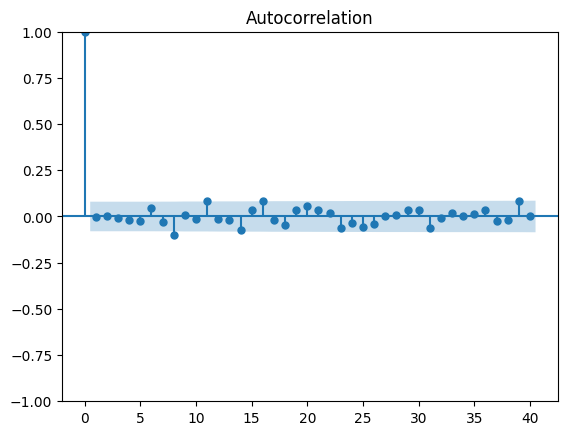

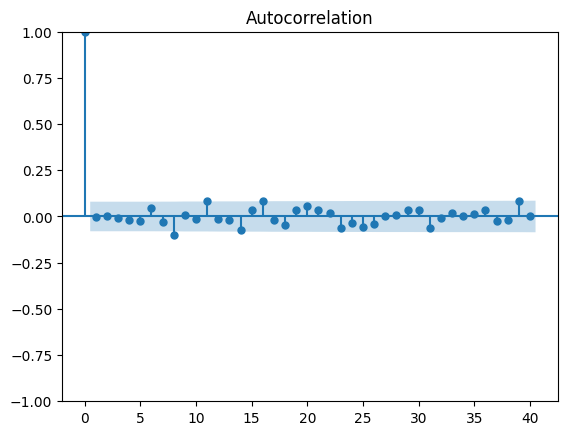

In [10]:
# This creates a graph of the autocorrelation function versus lags for the sales data
sm.graphics.tsa.plot_acf(sales_data['Units Sold'][0:600].values.squeeze(), lags=40)

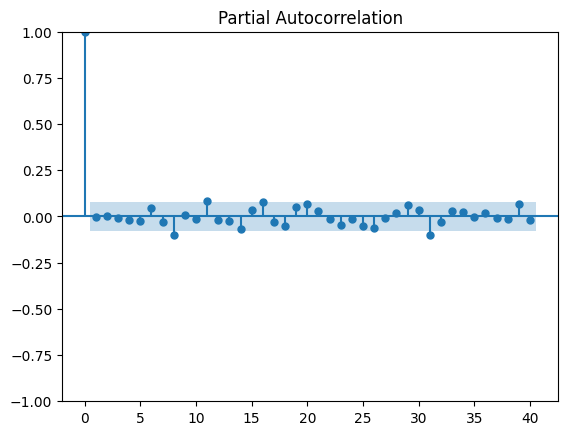

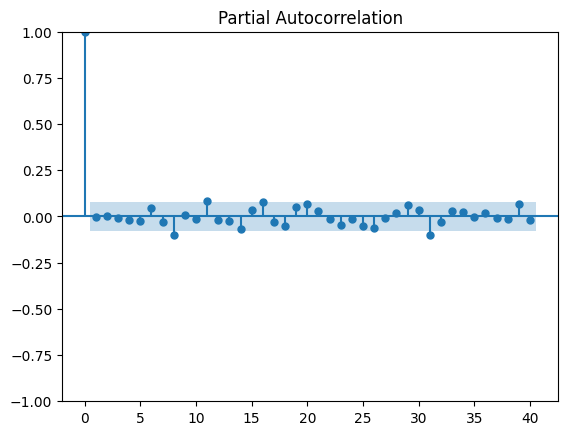

In [11]:
# This creates a graph of the partial autocorrelation function versus lags for the calls data
sm.graphics.tsa.plot_pacf(sales_data['Units Sold'][0:600].values.squeeze(), lags=40)

## Adding Lag Features

In [12]:
# Since there is no trending, we are not going to detrend
# But we will use use season of 1 week (7 days) and also use previous day's sales
sales_data['lag1 sales'] = sales_data['Units Sold'].shift(periods = 1)
sales_data['lag7 sales'] = sales_data['Units Sold'].shift(periods = 7)
# Due to the shift, the first 7 rows will have NaN that we drop
sales_data.dropna(inplace = True)
sales_data.head(10)

,Date,Inventory Level,Units Sold,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,lag1 sales,lag7 sales
7,2022-01-08,327,50,63.85,75.25,10,Rainy,1,72.17,145.00,4.00
8,2022-01-09,363,337,336.29,45.42,5,Sunny,0,48.52,50.00,2.00
9,2022-01-10,85,79,72.88,40.83,5,Rainy,1,37.97,337.00,353.00
10,2022-01-11,226,188,200.13,26.76,10,Sunny,1,23.06,79.00,202.00
11,2022-01-12,154,113,122.87,38.97,10,Snowy,1,39.36,188.00,189.00
12,2022-01-13,83,71,74.08,91.06,5,Rainy,1,87.75,113.00,30.00
13,2022-01-14,235,35,28.46,94.70,5,Snowy,1,96.42,71.00,145.00
14,2022-01-15,481,383,380.16,78.72,5,Sunny,0,79.95,35.00,50.00
15,2022-01-16,470,100,107.78,44.33,5,Sunny,0,45.48,383.00,337.00
16,2022-01-17,496,113,127.00,42.53,0,Rainy,0,41.27,100.00,79.00


In [13]:
# The 'Weather Condition' column is categorical; what are the categories?
set(sales_data['Weather Condition'])

{'Cloudy', 'Rainy', 'Snowy', 'Sunny'}

### Initially let us ignore the date and month

In [14]:
# Creating dummy variables and dropping first of the 4 types (does not add value here)
sales_data = pd.get_dummies(sales_data, drop_first=True)
sales_data.head()

,Date,Inventory Level,Units Sold,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,lag1 sales,lag7 sales,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny
7,2022-01-08,327,50,63.85,75.25,10,1,72.17,145.00,4.00,True,False,False
8,2022-01-09,363,337,336.29,45.42,5,0,48.52,50.00,2.00,False,False,True
9,2022-01-10,85,79,72.88,40.83,5,1,37.97,337.00,353.00,True,False,False
10,2022-01-11,226,188,200.13,26.76,10,1,23.06,79.00,202.00,False,False,True
11,2022-01-12,154,113,122.87,38.97,10,1,39.36,188.00,189.00,False,True,False


In [15]:
# We reset our index so our datafra starts with index 0
sales_data.reset_index(drop = True, inplace = True)
sales_data.head()

,Date,Inventory Level,Units Sold,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,lag1 sales,lag7 sales,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny
0,2022-01-08,327,50,63.85,75.25,10,1,72.17,145.00,4.00,True,False,False
1,2022-01-09,363,337,336.29,45.42,5,0,48.52,50.00,2.00,False,False,True
2,2022-01-10,85,79,72.88,40.83,5,1,37.97,337.00,353.00,True,False,False
3,2022-01-11,226,188,200.13,26.76,10,1,23.06,79.00,202.00,False,False,True
4,2022-01-12,154,113,122.87,38.97,10,1,39.36,188.00,189.00,False,True,False


## Uncomment following if we wish to add month and day-of-week

In [16]:
# # We can use the dates and day-of-week as features
# sales_data['month'] = sales_data['Date'].dt.month
# sales_data['day'] = sales_data['Date'].dt.weekday
# sales_data.head()
# sales_data.tail()

In [17]:
# We split the data into a training set and a testing set
train_data = sales_data[sales_data['Date'] < '2023-10-01']
test_data = sales_data[sales_data['Date'] >= '2023-10-01']

In [18]:
# Creating training data dropping columns not needed and also ground truth
X_train = train_data.drop(columns = ['Date', 'Units Sold'])
y_train = train_data['Units Sold']

## Gradient Boosting

In [19]:
# Defining the model and parameters
gb = GradientBoostingRegressor(n_estimators = 100, max_depth = 6, min_samples_leaf = 2)
# Asking the model to fit the training data
gb = gb.fit(X_train, y_train)
# Asking what the importance of features
gb.feature_importances_

array([7.49606664e-04, 9.96364518e-01, 4.04955184e-04, 2.55199985e-04,
       4.81676152e-05, 4.77335005e-04, 8.07049382e-04, 7.09093729e-04,
       7.61255754e-05, 6.50823071e-05, 4.28662505e-05])

In [20]:
# Define the testing data sets
X_test = test_data.drop(columns = ['Date', 'Units Sold'])
y_test = test_data['Units Sold']
# Make predictions
y_preds = gb.predict(X_test)
# Calculate percentage and absolute errors
perc_errors = np.abs(y_test-y_preds)/y_test
abs_errors = np.abs(y_test-y_preds)

In [21]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(perc_errors))
print('Median absolute percentage error:', np.median(perc_errors))
print('75th percentile of absolute percentage error:', np.percentile(perc_errors, 75))
print('90th percentile of absolute percentage error:', np.percentile(perc_errors, 90))

Mean absolute percentage error: 0.16038893077119518
Median absolute percentage error: 0.04997200488295784
75th percentile of absolute percentage error: 0.12055722555702886
90th percentile of absolute percentage error: 0.2731028140660671


In [22]:
# Print the absolute error ratio results
avg_test = test_data['Units Sold'].mean()
print('Mean absolute error ratio:', np.mean(abs_errors)/avg_test)
print('Median absolute error ratio:', np.median(abs_errors)/avg_test)
print('75th percentile absolute error ratio:', np.percentile(abs_errors, 75)/avg_test)
print('90th percentile absolute error ratio:', np.percentile(abs_errors, 90)/avg_test)

Mean absolute error ratio: 0.05015568411669761
Median absolute error ratio: 0.05040095547778137
75th percentile absolute error ratio: 0.07220548822944722
90th percentile absolute error ratio: 0.10051193848792561


## XGB

In [23]:
# Define the XGBoost regressor with specific hyperparameters
model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=1.0,
        objective='reg:squarederror',
        random_state=42
    )

# Train the model
model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
# Make predictions
y_preds = model.predict(X_test)
# Calculate percentage and absolute errors
perc_errors = np.abs(y_test-y_preds)/y_test
abs_errors = np.abs(y_test-y_preds)

In [25]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(perc_errors))
print('Median absolute percentage error:', np.median(perc_errors))
print('75th percentile of absolute percentage error:', np.percentile(perc_errors, 75))
print('90th percentile of absolute percentage error:', np.percentile(perc_errors, 90))

Mean absolute percentage error: 0.14560337048265637
Median absolute percentage error: 0.05269386494054203
75th percentile of absolute percentage error: 0.11896106175013951
90th percentile of absolute percentage error: 0.26287640513795785


In [26]:
# Print the absolute error ratio results
avg_test = test_data['Units Sold'].mean()
print('Mean absolute error ratio:', np.mean(abs_errors)/avg_test)
print('Median absolute error ratio:', np.median(abs_errors)/avg_test)
print('75th percentile absolute error ratio:', np.percentile(abs_errors, 75)/avg_test)
print('90th percentile absolute error ratio:', np.percentile(abs_errors, 90)/avg_test)

Mean absolute error ratio: 0.0495600253522746
Median absolute error ratio: 0.046871577861226595
75th percentile absolute error ratio: 0.07068208127474042
90th percentile absolute error ratio: 0.09630869787108132


## Random Forest

In [27]:
# Defining the model and parameters
rf = RandomForestRegressor(max_depth = 6, min_samples_leaf = 2, max_features = "sqrt")
# Asking the model to fit the training data
rf = rf.fit(X_train, y_train)
# Asking what the importance of features
rf.feature_importances_

array([0.20922268, 0.68573445, 0.02170609, 0.00819526, 0.00201183,
       0.02375236, 0.0184109 , 0.02400934, 0.00192432, 0.00316342,
       0.00186934])

In [28]:
# Make predictions
y_preds = rf.predict(X_test)
# Calculate percentage and absolute errors
perc_errors = np.abs(y_test-y_preds)/y_test
abs_errors = np.abs(y_test-y_preds)

In [29]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(perc_errors))
print('Median absolute percentage error:', np.median(perc_errors))
print('75th percentile of absolute percentage error:', np.percentile(perc_errors, 75))
print('90th percentile of absolute percentage error:', np.percentile(perc_errors, 90))

Mean absolute percentage error: 0.7523074588660357
Median absolute percentage error: 0.1080789124908347
75th percentile of absolute percentage error: 0.20591841752462087
90th percentile of absolute percentage error: 0.49941812225027915


In [30]:
# Print the absolute error ratio results
avg_test = test_data['Units Sold'].mean()
print('Mean absolute error ratio:', np.mean(abs_errors)/avg_test)
print('Median absolute error ratio:', np.median(abs_errors)/avg_test)
print('75th percentile absolute error ratio:', np.percentile(abs_errors, 75)/avg_test)
print('90th percentile absolute error ratio:', np.percentile(abs_errors, 90)/avg_test)

Mean absolute error ratio: 0.13711449507092077
Median absolute error ratio: 0.09641070533286433
75th percentile absolute error ratio: 0.19610118687614422
90th percentile absolute error ratio: 0.31467611361806963
